# Lab 1 Andrea Mirenda

In [2]:
import numpy as np
from itertools import accumulate
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from icecream import ic

c:\Users\andrea\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import the libraries

In [3]:
UNIVERSE_SIZE = 10_000
NUM_SETS = 1_000
DENSITY = 0.3 
rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [4]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

In [5]:
def valid(solution):
    """Controlla se la soluzione è valida (copre tutto l'universo)."""
    return np.all(np.sum(SETS[solution], axis=0) > 0)

def cost(solution):
    """Calcola il costo di una soluzione."""    
    return COSTS[solution].sum()

This function is used to count the number of elements covered by the current solution:

In [6]:
def satisfied_count(solution):
    """Restituisce il numero di elementi nell'universo che sono coperti dai set selezionati."""
    covered_elements = np.sum(SETS[solution], axis=0) > 0
    return np.sum(covered_elements)


With this code we aim at tweak the solution depending the cost of the set: sets with lower cost will be tweaked with more probability. 

Also, this function takes into account the "strength" of the mutation in order to be able to "perturbate" the current solution with a different strength depending on the provided parameter. The XOR operation is used to compute the "mutation".

Notice that this function can also provide an invalid solution.

In [7]:
def weighted_mutation(solution, strength=0.3):
    """Effettua la mutazione sulla soluzione con probabilità basata sui costi."""
    inverted_costs = 1 / COSTS
    probabilities = inverted_costs / inverted_costs.sum()
    mask = rng.random(NUM_SETS) < strength * probabilities
    if not np.any(mask):
        selected_set = rng.choice(NUM_SETS, p=probabilities)
        mask[selected_set] = True
    new_solution = np.logical_xor(solution, mask)
    return new_solution

We define the fitness function considering both the number of satisfied elements and the cost value avoiding to have local optimum into invalid regions.

In [8]:
def fitness(solution: np.ndarray):
    """Restituisce la fitness di una soluzione, bilanciando costo e copertura."""    
    coverage = satisfied_count(solution)
    cost_value = -1 * cost(solution)
    return (coverage, cost_value)

The fitness landscape takes into account the "validity" of the solution and the cost of the same solution. For the first one we avoid using a step function (valid/invalid) so that we can be more precise about the number of constraints we are violating.
The cost is inverted and the function returns a tuple of the 2 elements.

## Simulated anneling

In [9]:
def simulated_annealing_accept(new_fitness, current_fitness, temperature):
    """Accetta una nuova soluzione con probabilità basata sulla temperatura."""
    if new_fitness > current_fitness:
        return True
    else:
        delta_fitness = (current_fitness[1] - new_fitness[1]) / temperature
        #per evitare l'overflow andiamo a limitare la variazione:
        delta_fitness = np.clip(delta_fitness, -500, 500)
        return np.exp(delta_fitness) > rng.random()

ic| float(fitness(solution)[1]): -6684027.119772501
100%|██████████| 1000/1000 [00:33<00:00, 29.72it/s]
ic| float(fitness(solution)[1]): -3443649.406867575


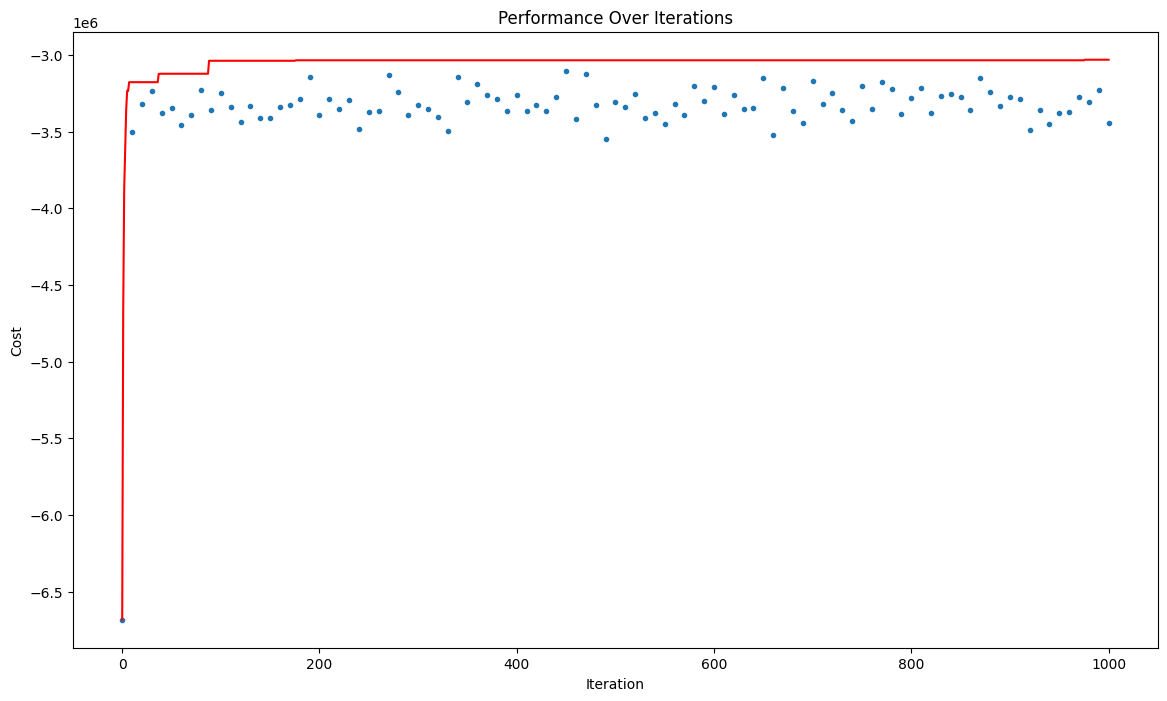

In [10]:

def multiple_mutation(solution, strength=0.3):
    mask=rng.random(NUM_SETS)<strength
    #verifico se la mask e tutta di zeri:
    if not np.any(mask):
	    #devo mettere almeno un uno:
	    #mask[rng.random.eandint(NUM_SETS)]=True
        mask[rng.integers(NUM_SETS)] = True
    new_solution=np.logical_xor(solution, mask)
    return new_solution


ITERATIONS = 1000
solution= rng.random(NUM_SETS)<1
history = [float(fitness(solution)[1])]

ic(float(fitness(solution)[1]))

for steps in tqdm(range(ITERATIONS)):
    new_solution = multiple_mutation(solution)
    new_fitness = fitness(new_solution)
    history.append(float(new_fitness[1]))

    temperature = 1.0 * (0.01 / 1.0) ** (steps / ITERATIONS)  # Vado a ridurew la temperatura

    if simulated_annealing_accept(new_fitness, fitness(solution), temperature):
        solution = new_solution
        
ic(float(fitness(solution)[1]))
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
plt.scatter(range(0, len(history), 10), history[::10], marker=".")
plt.title('Performance Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.show()

# With self adaptive strength parameter

100%|██████████| 276/276 [00:05<00:00, 53.15it/s]


ris finale -2881892.8961634366


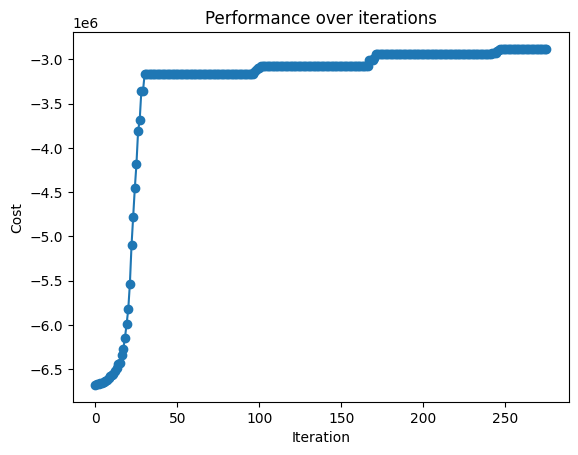

In [11]:
# Punto di partenza:
solution= rng.random(NUM_SETS)<1
history = []

buffer = []
lunghezza = int(int(DENSITY*100 * np.log(UNIVERSE_SIZE)) / 7)
solution_fitness = (0, -np.inf) 

step_size = 0.1

for steps in tqdm(range(int(DENSITY*100 * np.log(UNIVERSE_SIZE)))):
    if steps < int(DENSITY*100 * np.log(UNIVERSE_SIZE)) * 0.2:
        new_solution = weighted_mutation(solution, strength=step_size * 4) 
    else:
        new_solution = weighted_mutation(solution, strength=step_size)

    new_fitness = fitness(new_solution)
    
    buffer.append(new_fitness > solution_fitness)
    
    # Se trovo una soluzione migliore, aggiorno
    if new_fitness > solution_fitness:
        solution_fitness = new_fitness
        solution = new_solution

    history.append(float(solution_fitness[1]))

    if len(buffer) > lunghezza:
        buffer.pop(0)

    if np.sum(buffer) > 1:
        step_size = step_size + 0.3*step_size
    else:
        step_size = step_size - 0.3*step_size

print("ris finale", fitness(solution)[1])
plt.plot(range(0, len(history)), history, marker='o')  
plt.title("Performance over iterations")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()


# Improvements after the reviews 

## Suggestion of Massimo Francios

The code is clear and well-explained, making it easy to follow and understand.
You applied two different approach: one based on simulated annealing and the other on RMHC.
The simulated annealing approach is effective because it allows the algorithm to escape local optima, and provides a better exploration of the search space. I appreciate your use of a multiple tweak function based on a mask.

In the second approach i find your weighted_mutation function particularly interesting because it allows the algorithm to tweak sets based on their costs. Additionally, your algorithm has a self-adaptive strength parameter which enables a dynamic mutations.

These are good ideas that facilitate the algorithm's ability to self-learn and better handle the problem.

One possible improvement could be mixing the two strategies you employed by including your self-adaptive strength into simulated annealing; this could enhance exploration.
I also noticed that you started with an all True solution, which is valid, but starting from a random solution could significantly reduce computational waste and improve efficiency.

Overall, great job!

In [12]:
def simulated_annealing_with_adaptive_strength(
    initial_solution, 
    objective_function, 
    neighbor_function, 
    initial_temperature, 
    final_temperature, 
    cooling_rate, 
    adaptive_strength_update
):
    """
    Combines simulated annealing with self-adaptive strength.

    Args:
        initial_solution: Starting solution.
        objective_function: Function to minimize.
        neighbor_function: Function to generate a neighbor of the current solution.
        initial_temperature: Starting temperature.
        final_temperature: Ending temperature.
        cooling_rate: Cooling factor (e.g., 0.95).
        adaptive_strength_update: Function to update the self-adaptive strength.

    Returns:
        best_solution: The best solution found.
        best_cost: The cost of the best solution.
    """
    # Initialization
    current_solution = initial_solution
    current_cost = objective_function(current_solution)
    best_solution = current_solution
    best_cost = current_cost
    
    temperature = initial_temperature
    adaptive_strength = 1.0  # Initial value for the self-adaptive strength
    
    while temperature > final_temperature:
        # Generate a new neighbor solution
        new_solution = neighbor_function(current_solution)
        new_cost = objective_function(new_solution)
        
        # Calculate the cost difference
        delta_cost = new_cost - current_cost
        
        # Accept or reject the new solution
        if delta_cost < 0 or np.random.rand() < np.exp(-delta_cost / (adaptive_strength * temperature)):
            current_solution = new_solution
            current_cost = new_cost
            
            # Update the best solution if necessary
            if current_cost < best_cost:
                best_solution = current_solution
                best_cost = current_cost

        # Update the self-adaptive strength (e.g., based on progress)
        adaptive_strength = adaptive_strength_update(adaptive_strength, temperature, delta_cost)
        
        # Cool down the temperature
        temperature *= cooling_rate

    return best_solution, best_cost

# Example function to update self-adaptive strength
def adaptive_strength_update_example(current_strength, temperature, delta_cost):
    """
    Updates the self-adaptive strength based on the temperature and cost difference.
    """
    # Reduce strength for large positive deltas (favor exploration)
    if delta_cost > 0:
        return current_strength * (1 + 0.1 * np.log(1 + delta_cost))
    # Slightly reduce strength for negative deltas (favor exploitation)
    else:
        return current_strength * 0.99  # Gradual decay for stability
    



In [ ]:
# Parameters
initial_solution = 5  # Starting point
initial_temperature = 100
final_temperature = 1e-3
cooling_rate = 0.9

# Run the algorithm
best_solution, best_cost = simulated_annealing_with_adaptive_strength(
    initial_solution,
    cost,
    neighbor_function,
    initial_temperature,
    final_temperature,
    cooling_rate,
    adaptive_strength_update_example
)
print(best_solution)
print(best_cost)

NameError: name 'objective_function' is not defined